In [1]:
import gc
import warnings
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve,
    roc_auc_score,
    PrecisionRecallDisplay,
    log_loss,
    RocCurveDisplay
)

from intent_model.preprocessing.targets import rh_vs_rest_target

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_parquet('data/rh/dataset_v4/dataset_2.pq')

In [4]:
data.columns

Index(['valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
       'latitude', 'longitude', 'is_trip_ended', 'service', 'quantile',
       'weekday', 'minutes_sin', 'minutes_cos', 'is_weekend', 'rh',
       'norm_week', 'norm_hour', 'norm_hour_denoised', 'min_dist_to_known_loc',
       'norm_trips_curr_location', 'is_freq', 'dist_to_most_freq',
       'dist_to_second_freq', 'is_home', 'is_work', 'has_saved', 'rh_frac'],
      dtype='object')

In [5]:
data.head()

,valid_date,ts,sessionuuid,customer_id,booking_id,latitude,longitude,is_trip_ended,service,quantile,...,norm_hour_denoised,min_dist_to_known_loc,norm_trips_curr_location,is_freq,dist_to_most_freq,dist_to_second_freq,is_home,is_work,has_saved,rh_frac
0,2023-06-27,2023-06-27 04:00:00,FFE53ECB-C04C-442F-9909-BE79185ECFD4,55350252,1775612463,25.23440,55.26050,1,rh,0.97,...,0.068680,0.067139,0.973248,0,0.067139,4.598149,0,0,1,0.731707
1,2023-06-27,2023-06-27 04:00:00,3F378D1F-621C-482C-8CB0-2FDF87644D4A,18332590,0,25.04376,55.25076,0,rh,0.98,...,0.015284,6.566052,0.000000,0,7.396961,11.299689,0,0,1,1.000000
2,2023-06-27,2023-06-27 04:00:00,FF06FA4E-737F-4803-ACAF-9EB15CCACBE5,46610104,0,25.01181,55.29931,0,rh,0.93,...,0.000000,0.037711,0.951034,0,0.037711,2.746468,1,0,1,0.970588
3,2023-06-27,2023-06-27 04:00:00,C111D52E-D41C-4523-B4A9-F435C27630CA,31738098,0,25.04223,55.25033,0,rh,0.97,...,0.027369,0.041944,0.120313,0,4.114068,13.323311,0,0,1,0.983607
4,2023-06-27,2023-06-27 04:00:01,977C1A64-F339-4350-A384-73C78A2A3D64,52646559,0,25.20758,55.26808,0,rh,0.86,...,0.000000,0.047390,0.816968,0,0.047390,9.606694,0,0,0,1.000000


In [6]:
data.dtypes

valid_date                          object
ts                          datetime64[ns]
sessionuuid                         object
customer_id                          int64
booking_id                           int64
latitude                           float64
longitude                          float64
is_trip_ended                        int64
service                             object
quantile                           float64
weekday                             object
minutes_sin                        float64
minutes_cos                        float64
is_weekend                           int64
rh                                   int64
norm_week                          float64
norm_hour                          float64
norm_hour_denoised                 float64
min_dist_to_known_loc              float64
norm_trips_curr_location           float64
is_freq                              int64
dist_to_most_freq                  float64
dist_to_second_freq                float64
is_home    

In [7]:
data.weekday.unique()

array(['2', '3', '4', '5', '6', '7', '1'], dtype=object)

In [8]:
data[['ts', 'weekday']]

,ts,weekday
0,2023-06-27 04:00:00,2
1,2023-06-27 04:00:00,2
2,2023-06-27 04:00:00,2
3,2023-06-27 04:00:00,2
4,2023-06-27 04:00:01,2
...,...,...
10525092,2023-09-25 02:58:33,1
10525093,2023-09-25 02:58:33,1
10525094,2023-09-25 02:58:34,1
10525095,2023-09-25 02:59:23,1


In [9]:
data = rh_vs_rest_target(data)

In [10]:
data[data.rh == 1].is_freq.value_counts()

0    4424007
1    3228468
Name: is_freq, dtype: int64

In [11]:
TO_DROP = [
    'valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
    'is_trip_ended', 'rh', 'is_freq', 'service', 'is_work', 'has_saved', 'weekday', # 'target'
    'norm_hour_denoised',
    # 'norm_hour',
    # 'quantile',
    # 'num_trips', 'trx_amt'
]

In [12]:
CAT = ['is_home', 'is_weekend']

for col in CAT:
    data[col] = data[col].astype(str)

## Time-based Split

In [13]:
dates = np.sort(data.valid_date.unique())

train = data[data.valid_date.isin(dates[:60])].copy()
val = data[data.valid_date.isin(dates[60:75])].copy()
test = data[data.valid_date.isin(dates[75:])].copy()

In [14]:
train['sample_weight'] = 1.0
train.loc[(train.rh == 1) & (train.is_freq == 0), 'sample_weight'] = 0.75
train.loc[(train.rh == 1) & (train.is_trip_ended == 0), 'sample_weight'] = 0.5

In [15]:
train.target.value_counts()

1    4745949
0    1804466
Name: target, dtype: int64

In [16]:
val["sample_weight"] = 1.0

In [17]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train.drop(TO_DROP, axis=1),
    label="target",
    weight="sample_weight",
    batch_size=4096
)

val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    val.drop(TO_DROP, axis=1),
    label="target",
    weight="sample_weight",
    batch_size=4096
)

Metal device set to: Apple M1 Pro


2023-10-30 21:02:51.072279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-30 21:02:51.072300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
train.drop(TO_DROP, axis=1).columns

Index(['latitude', 'longitude', 'quantile', 'minutes_sin', 'minutes_cos',
       'is_weekend', 'norm_week', 'norm_hour', 'min_dist_to_known_loc',
       'norm_trips_curr_location', 'dist_to_most_freq', 'dist_to_second_freq',
       'is_home', 'rh_frac', 'target', 'sample_weight'],
      dtype='object')

In [19]:
train_ds

<_PrefetchDataset element_spec=({'latitude': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'longitude': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'quantile': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'minutes_sin': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'minutes_cos': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'is_weekend': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'norm_week': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'norm_hour': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'min_dist_to_known_loc': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'norm_trips_curr_location': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'dist_to_most_freq': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'dist_to_second_freq': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'is_home': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'rh_frac': TensorSpec(shap

### Small EDA

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [21]:
df = train.drop(TO_DROP + CAT + ['target', 'sample_weight'], axis=1).sample(n=20000)
vif_df = pd.DataFrame()
vif_df['feature'] = df.columns
vif_df['VIF'] = [vif(df.values, i) for i in range(len(df.columns))]
vif_df

,feature,VIF
0,latitude,117.061375
1,longitude,58.340624
2,quantile,286.032500
3,minutes_sin,1.341943
4,minutes_cos,1.180259
5,norm_week,3.993144
6,norm_hour,2.024605
7,min_dist_to_known_loc,1.350200
8,norm_trips_curr_location,3.670982
9,dist_to_most_freq,1.413320


### Model

In [22]:
model = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.builder.Task.CLASSIFICATION,
    num_trees=200,
    max_depth=None,
    max_num_nodes=64,  # 32
    growing_strategy='BEST_FIRST_GLOBAL',
    categorical_algorithm='CART',
    loss = 'BINARY_FOCAL_LOSS',
    subsample=0.9,
    validation_ratio=0.1,
    random_seed=42
)

Use /var/folders/gz/t4xrdmr90n7gd4ht88yqz2mc0000gn/T/tmpgisff_iw as temporary training directory


[WARNING 23-10-30 21:02:53.0780 +04 gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-30 21:02:53.0824 +04 gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-10-30 21:02:53.0825 +04 gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [23]:
model = tf.keras.models.load_model('models/tfdf_focal_latest')

2023-10-30 21:02:53.408148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
[INFO 23-10-30 21:02:53.4103 +04 kernel.cc:1243] Loading model from path models/tfdf_focal_latest/assets/ with prefix d398c437e6614c8c
[INFO 23-10-30 21:02:53.4421 +04 abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-10-30 21:02:53.4421 +04 kernel.cc:1075] Use fast generic engine
2023-10-30 21:02:53.448258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 21:02:53.454566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [24]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test.drop(TO_DROP + ['target'], axis=1), batch_size=4096)

In [25]:
ppreds = model.predict(test_ds).flatten()
preds = np.where(ppreds > 0.5, 1, 0)

  8/494 [..............................] - ETA: 8s

2023-10-30 21:02:54.053504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


494/494 [==============================] - 9s 18ms/step


### Evaluation

In [26]:
from IPython.core.display import display as idisplay, HTML
from intent_model.functions import get_optimal_threshold

In [27]:
cb_test_y = test.target.values

In [28]:
log_loss(cb_test_y, ppreds)

0.4775253512640443

In [29]:
roc_auc_score(cb_test_y, ppreds)

0.8738268810089538

In [30]:
print(classification_report(cb_test_y, preds))

              precision    recall  f1-score   support

           0       0.68      0.65      0.67    536095
           1       0.88      0.89      0.88   1484287

    accuracy                           0.83   2020382
   macro avg       0.78      0.77      0.77   2020382
weighted avg       0.82      0.83      0.83   2020382



In [31]:
idisplay(HTML(tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=5)))

2023-10-30 21:03:10.381920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [32]:
target_thresh, expected_recall = get_optimal_threshold(cb_test_y, ppreds, 0.9)

print(target_thresh)
print(expected_recall)

0.5434836
0.8403893586617682


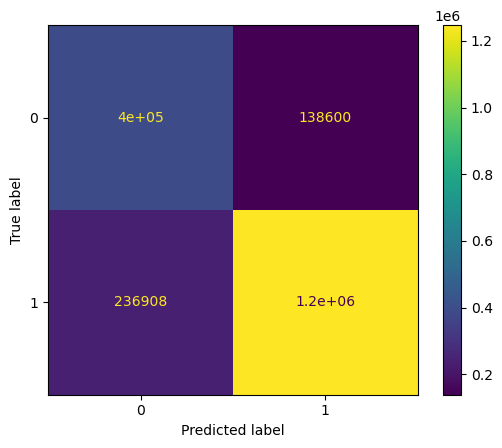

In [33]:
threshold = target_thresh

cm = confusion_matrix(cb_test_y, np.where(ppreds > threshold, 1, 0))
cm_display = ConfusionMatrixDisplay(cm).plot()

In [34]:
print(classification_report(cb_test_y, np.where(ppreds > threshold, 1, 0)))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68    536095
           1       0.90      0.84      0.87   1484287

    accuracy                           0.81   2020382
   macro avg       0.76      0.79      0.77   2020382
weighted avg       0.83      0.81      0.82   2020382



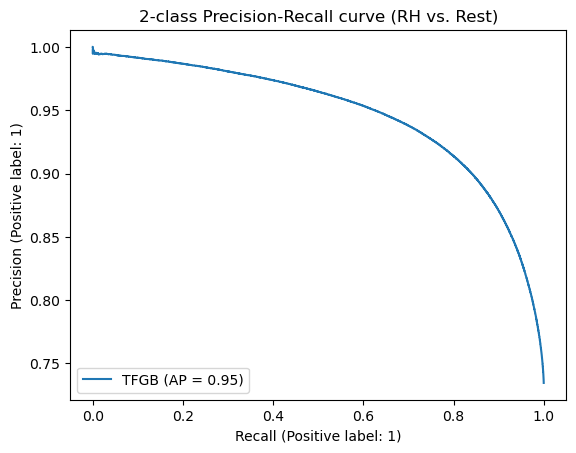

In [35]:
display = PrecisionRecallDisplay.from_predictions(cb_test_y, ppreds, name="TFGB")
_ = display.ax_.set_title("2-class Precision-Recall curve (RH vs. Rest)")

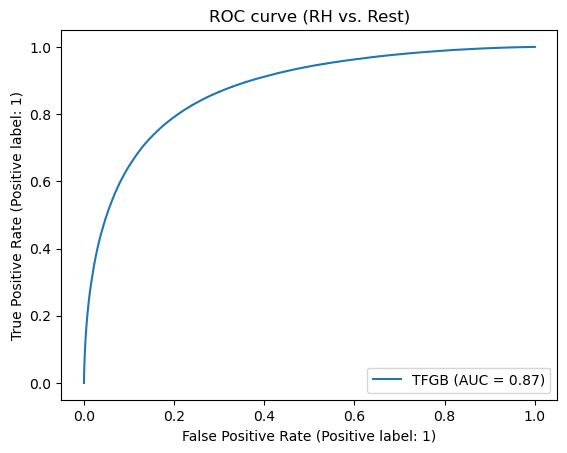

In [36]:
display = RocCurveDisplay.from_predictions(cb_test_y, ppreds, name="TFGB")
_ = display.ax_.set_title("ROC curve (RH vs. Rest)")

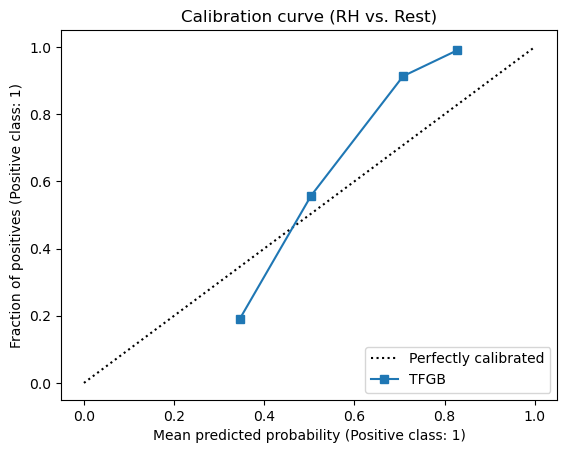

In [37]:
display = CalibrationDisplay.from_predictions(cb_test_y, ppreds, name="TFGB")
_ = display.ax_.set_title("Calibration curve (RH vs. Rest)")

### Calibration

In [198]:
import importlib
import tf_isotonic

importlib.reload(tf_isotonic)

<module 'tf_isotonic' from '/Users/andreychubin/Desktop/DS/SA/MS-Intent/tf_isotonic.py'>

In [199]:
from tf_isotonic import TFIsotonicRegression

In [154]:
def expected_calibration_error(samples, true_labels, M=3):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

   # keep confidences / predicted "probabilities" as they are
    confidences = samples
    # get binary class predictions from confidences
    predicted_label = (samples>0.5).astype(float)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prop_in_bin = in_bin.astype(float).mean()

        if prop_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].astype(float).mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

In [91]:
iso_ds = train[['target']].values.flatten()
train_preds = model.predict(train_ds).flatten()

1600/1600 [==============================] - 32s 20ms/step


In [200]:
iso = TFIsotonicRegression(y_min=0.0, y_max=1.0, increasing=True, approximation=7)

In [202]:
iso.fit(x=train_preds, y=iso_ds, batch_size=100000, verbose=True)

2023-10-31 17:25:21.923819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-31 17:25:21.926427: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9


Progress: [____________________]  [2/65]

2023-10-31 17:25:22.155165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Progress: [▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩_]  [63/65]

2023-10-31 17:25:28.455464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Progress: [▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩]  [64/65]

2023-10-31 17:25:30.410735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-31 17:25:30.441029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-31 17:25:33.009270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Progress: [▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩▩]  [65/65]

2023-10-31 17:25:37.387241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


TFIsotonicRegression(y_min=0.0, y_max=1.0, increasing=True, approximation=7)

In [203]:
ppreds_scaled = iso.predict(ppreds, batch_size=100000)

21/21 [==============================] - 0s 5ms/step


2023-10-31 17:25:46.889954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-31 17:25:46.893414: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: tf_isotonic_regression_6/StatefulPartitionedCall/StatefulPartitionedCall/assert_equal_1/Assert/AssertGuard/branch_executed/_24


In [204]:
iso.save('models/isotonic')

In [205]:
iso_l = tf.keras.models.load_model('models/isotonic')

In [207]:
ppreds_scaled = iso.predict(ppreds[:2], verbose=False)#.numpy().flatten().astype(np.float64)

In [208]:
ppreds_scaled

array([0.8423905 , 0.62082064], dtype=float32)

In [183]:
iso.call(ppreds)

2023-10-31 13:28:25.018785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(2020382,), dtype=float32, numpy=
array([0.8423905 , 0.62082064, 0.6671446 , ..., 0.32947975, 0.9355774 ,
       0.        ], dtype=float32)>

In [184]:
iso(ppreds)

<tf.Tensor: shape=(2020382,), dtype=float32, numpy=
array([0.8423905 , 0.62082064, 0.6671446 , ..., 0.32947975, 0.9355774 ,
       0.        ], dtype=float32)>

In [136]:
ppreds_scaled

<tf.Tensor: shape=(2020382,), dtype=float32, numpy=
array([0.8423905 , 0.62082064, 0.6671446 , ..., 0.32947975, 0.9355774 ,
       0.        ], dtype=float32)>

In [140]:
isinstance(iso, tf.Module)

True

In [122]:
expected_calibration_error(ppreds, cb_test_y, M=500)

array([0.20905042])

In [127]:
expected_calibration_error(ppreds_scaled, cb_test_y, M=500)

array([0.10184085])

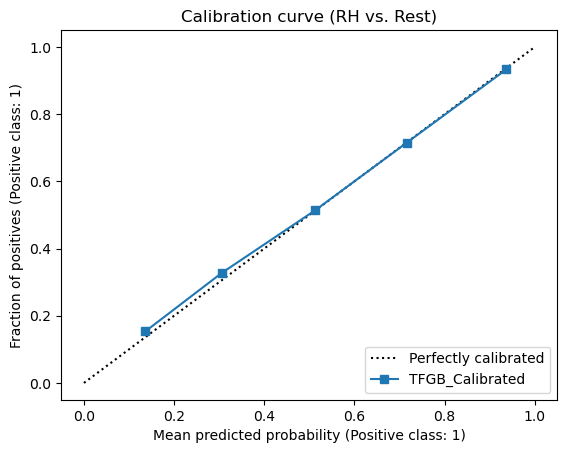

In [109]:
display = CalibrationDisplay.from_predictions(cb_test_y, ppreds_scaled, name="TFGB_Calibrated")
_ = display.ax_.set_title("Calibration curve (RH vs. Rest)")

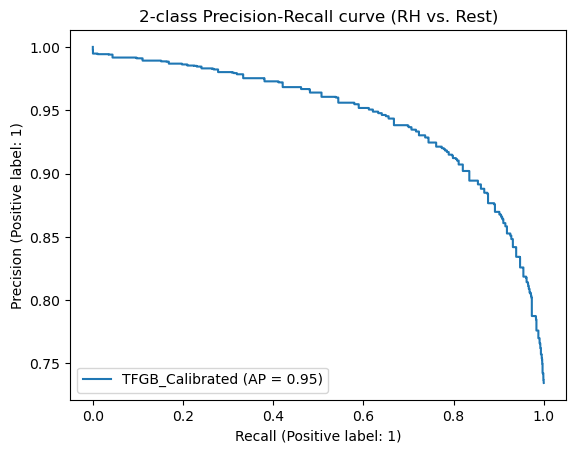

In [98]:
display = PrecisionRecallDisplay.from_predictions(cb_test_y, ppreds_scaled, name="TFGB_Calibrated")
_ = display.ax_.set_title("2-class Precision-Recall curve (RH vs. Rest)")

In [99]:
c_target_thresh, c_expected_recall = get_optimal_threshold(cb_test_y, ppreds_scaled, 0.9)

print(c_target_thresh)
print(c_expected_recall)

0.6527366042137146
0.8349658792403356


In [128]:
log_loss(cb_test_y, ppreds_scaled)

0.38119057136831674

In [101]:
roc_auc_score(cb_test_y, ppreds_scaled)

0.8737299210631879

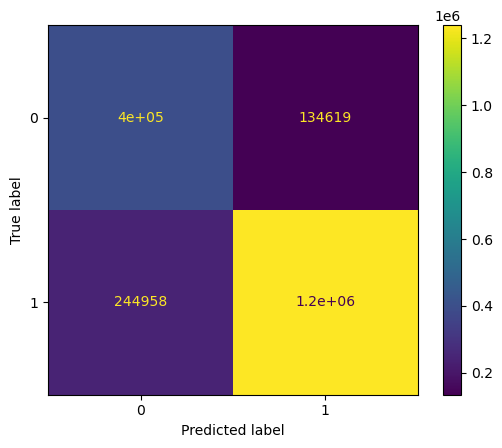

In [102]:
threshold = c_target_thresh

cm = confusion_matrix(cb_test_y, np.where(ppreds_scaled > threshold, 1, 0))
cm_display = ConfusionMatrixDisplay(cm).plot()

### Linear adj

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lin_train = train[['ts', 'is_work', 'target']].copy()
lin_train['is_evening'] = (pd.to_datetime(lin_train['ts']).dt.hour > 16).astype(int)
lin_train['score'] = train_preds.flatten()
lin_train = lin_train[lin_train.is_work == 1]
print(len(lin_train))

lin_test = test[['ts', 'is_work', 'target']].copy()
lin_test['is_evening'] = (pd.to_datetime(lin_test['ts']).dt.hour > 16).astype(int)
lin_test['score'] = ppreds
lin_test = lin_test[lin_test.is_work == 1]
print(len(lin_test))

In [ ]:
log_loss(lin_test.target.values, lin_test.score.values)

In [ ]:
roc_auc_score(lin_test.target.values, lin_test.score.values)

In [ ]:
lin = LinearRegression(positive=True, n_jobs=-1)

lin.fit(X=lin_train[['score', 'is_evening']].values, y=lin_train.target.values)

In [ ]:
ppreds_adj = iso.predict(lin.predict(lin_test[['score', 'is_evening']].values))

In [ ]:
log_loss(lin_test.target.values, ppreds_adj)

In [ ]:
roc_auc_score(lin_test.target.values, ppreds_adj)

In [ ]:
lin.coef_

In [ ]:
lin.intercept_

In [ ]:
iso.predict(lin.predict(np.array([[0.6, 1.0]])))

In [ ]:
display = CalibrationDisplay.from_predictions(lin_test.target.values, np.clip(ppreds_adj, 0.0, 1.0), name="Lin")
_ = display.ax_.set_title("Calibration curve (RH vs. Rest)")

### SHAP

In [ ]:
import shap

shap.__version__

In [ ]:
shap.initjs()

In [ ]:
ds_test = test.drop(TO_DROP + ['target'], axis=1)

In [ ]:
len(ds_test)

In [ ]:
def f(X: np.ndarray):
    ds = pd.DataFrame(data=X, columns=ds_test.columns)
    ds = tfdf.keras.pd_dataframe_to_tf_dataset(ds)
    return model.predict(ds, verbose=0).flatten()


def f_calibrated(X: np.ndarray):
    preds = f(X)
    return iso.predict(preds).flatten()

In [ ]:
explainer = shap.KernelExplainer(f, ds_test.iloc[:10], feature_names=ds_test.columns)

In [ ]:
_, shap_data = train_test_split(test, test_size=2000, stratify=test[['target', 'is_freq', 'is_home']])
shap_data = shap_data.drop(TO_DROP + ['target'], axis=1)

shap_values = explainer.shap_values(shap_data, nsamples=100, silent=True)

In [ ]:
shap.plots.beeswarm(shap.Explanation(shap_values, feature_names=ds_test.columns, data=shap_data), max_display=20)

### Additional Sanity Check

In [ ]:
from intent_model.functions import get_relevance

In [ ]:
res_df = get_relevance(test, test_ds, model, thresholds=np.linspace(0.1, 0.95, num=12))

res_df

In [ ]:
class IsoModelWrapper(object):    
    def predict(self, data, verbose: int = 0):
        preds = model.predict(data, verbose=verbose).flatten()
        return iso.predict(preds)
    
cal_model = IsoModelWrapper()


res_df = get_relevance(test, test_ds, cal_model, thresholds=np.linspace(0.1, 0.95, num=12))

res_df

In [ ]:
gc.collect()

### User Check

In [ ]:
import tensorflow as tf

In [ ]:
focal_model = tf.keras.models.load_model('models/tfdf_2_denoised')

TO_DROP = [
    'valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
    'is_trip_ended', 'rh', 'is_freq', 'service', 'is_work', 'has_saved', 'weekday', # 'target'
    # 'norm_hour_denoised',
    # 'quantile',
    # 'num_trips', 'trx_amt'
]

f_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train.drop(TO_DROP + ['target', 'sample_weight'], axis=1), batch_size=4096)
f_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test.drop(TO_DROP + ['target'], axis=1), batch_size=4096)

In [ ]:
focal_preds = focal_model.predict(f_test_ds)
train_focal_preds = focal_model.predict(f_train_ds)

iso = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip', increasing='auto')
iso.fit(X=train_focal_preds, y=iso_ds)

focal_preds_cal = iso.predict(focal_preds)

In [ ]:
focal_target_thresh, _ = get_optimal_threshold(cb_test_y, focal_preds, 0.9)
c_focal_target_thresh, _ = get_optimal_threshold(cb_test_y, focal_preds_cal, 0.9)

In [ ]:
check_test = test.copy()

check_test['score'] = ppreds
check_test['calibrated_score'] = ppreds_scaled
check_test['uncalib_decision'] = (check_test['score'] > target_thresh).astype(int)
check_test['calib_decision'] = (check_test['calibrated_score'] > c_target_thresh).astype(int)

check_test['focal_score'] = focal_preds
check_test['focal_calibrated_score'] = focal_preds_cal
check_test['uncalib_focal_decision'] = (check_test['focal_score'] > focal_target_thresh).astype(int)
check_test['calib_focal_decision'] = (check_test['focal_calibrated_score'] > c_focal_target_thresh).astype(int)

check_test[(check_test.customer_id == 54737848) & (check_test.target == 1)]  # 50794794 54737848

### TF Isotonic

In [ ]:
import os
import numpy as np
from scipy import interpolate

import tensorflow as tf

In [ ]:
def tf_lexsort(keys):
    assert len(keys) == 2, "Only 2 features are supported."
    m = to_matrix(keys[0], keys[1])
    b = tf.add(tf.slice(m, [0, 0], [-1, 1]) * 10, tf.slice(m, [0, 1], [-1, 1]))
    indices = tf.nn.top_k(b[:, 0], k=m.shape[0], sorted=False).indices
    return tf.reverse(indices, axis=[0])

In [ ]:
class TFIsotonicRegression(tf.Module):
    def __init__(self, y_min=None, y_max=None, increasing=True):
        self.y_min = y_min
        self.y_max = y_max
        self.increasing = increasing
    
    @staticmethod
    def to_matrix(x1, x2):
        if len(x1.shape) == 1:
            x1 = tf.expand_dims(x1, axis=-1)
        if len(x2.shape) == 1:
            x2 = tf.expand_dims(x2, axis=-1)  
        return tf.concat((x1, x2), axis=-1)

    def tf_groupby(self, x1, x2) -> tf.Tensor:
        tensor = self.to_matrix(x1, x2)
        sorted_indices = tf.argsort(tensor[:, 0])
        sorted_tensor = tf.gather(tensor, sorted_indices)

        unique_keys, _, num_group = tf.unique_with_counts(sorted_tensor[:, 0])
        aggregated_values = tf.zeros_like(unique_keys, dtype=tf.float32)

        start_idx = 0
        for i, count in enumerate(num_group):
            group = sorted_tensor[start_idx:start_idx+count, 1]
            index = tf.constant([[i]])
            value = tf.expand_dims(tf.reduce_mean(group), axis=0)
            aggregated_values = tf.tensor_scatter_nd_update(aggregated_values, index, value)
            start_idx += count

        return unique_keys, aggregated_values

    @staticmethod
    @tf.function(input_signature=[
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    ])
    def linear_interp1d(x, y, new_x):
        # Find the indices in x where values just below new_x are located
        indices_below = tf.searchsorted(x, new_x, side='right') - 1
        indices_below = tf.clip_by_value(indices_below, 0, tf.shape(x)[0]-2)

        # Find the corresponding x and y values for these indices
        x_below = tf.gather(x, indices_below)
        y_below = tf.gather(y, indices_below)

        x_above = tf.gather(x, indices_below + 1)
        y_above = tf.gather(y, indices_below + 1)

        # Compute the interpolated y values
        slope = (y_above - y_below) / (x_above - x_below)
        interpolated_y = y_below + slope * (new_x - x_below)

        return interpolated_y
    
    def _build_f(self, X, y):
        if len(y) == 1:
            self.f_ = lambda x: tf.repeat(y, len(X))
        else:
            self.f_ = lambda x: self.linear_interp1d(X, y, x)
    
    def _build_y(self, X, y):
        unique_X, unique_y = self.tf_groupby(X, y)
        iso_y = tf.clip_by_value(
            tf.nn.isotonic_regression(unique_y, decreasing=not self.increasing)[0],
            self.y_min,
            self.y_max
        )

        self.X_min_, self.X_max_ = tf.reduce_min(unique_X), tf.reduce_max(unique_X)
        return unique_X, iso_y 
    
    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = tf.convert_to_tensor(X, dtype=tf.float32)
        if isinstance(y, np.ndarray):
            y = tf.convert_to_tensor(y, dtype=tf.float32)
            
        X_iso, y_iso = self._build_y(X, y)
        self._build_f(X_iso, y_iso)
        return self
    
    def predict(self, T):
        assert hasattr(self, "f_"), "Model is not fitted"
        
        if isinstance(T, np.ndarray):
            T = tf.convert_to_tensor(T, dtype=tf.float32)
            
        T = tf.clip_by_value(T, self.X_min_, self.X_max_)
        return self.f_(T)
    
    @tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.float32)])
    def __call__(self, T):
        return self.predict(T)
    
    def __repr__(self):
        return f"TFIsotonicRegression(y_min={self.y_min}, y_max={self.y_max}, increasing={self.increasing})"


In [ ]:
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('ERROR')


class FastTFIsotonicRegression(tf.Module):
    def __init__(self, y_min=None, y_max=None, increasing=True, approximate=False):
        self.y_min = y_min
        self.y_max = y_max
        self.increasing = increasing
        self.approximate = approximate
        self.accumulated_X = tf.constant([], dtype=tf.float32)
        self.accumulated_y = tf.constant([], dtype=tf.float32)
    
    @staticmethod
    @tf.function
    def to_matrix(x1, x2):
        x1, x2 = [tf.expand_dims(t, axis=-1) if len(t.shape) == 1 else t for t in [x1, x2]]
        return tf.concat((x1, x2), axis=-1)
    
    @staticmethod
    @tf.function
    def in1d(arr1, arr2):
        arr1 = tf.expand_dims(arr1, 1)
        arr2 = tf.expand_dims(arr2, 0)
        return tf.reduce_any(tf.reduce_any(tf.equal(arr1, arr2), axis=1))

    @tf.function
    def tf_groupby(self, x1, x2) -> tf.Tensor:
        tensor = self.to_matrix(x1, x2)
        sorted_indices = tf.argsort(tensor[:, 0])
        sorted_tensor = tf.gather(tensor, sorted_indices)

        unique_keys, idx, counts = tf.unique_with_counts(sorted_tensor[:, 0])
        sum_values = tf.math.unsorted_segment_sum(sorted_tensor[:, 1], idx, tf.shape(unique_keys)[0])
        aggregated_values = sum_values / tf.cast(counts, tf.float32)

        return unique_keys, aggregated_values

    @staticmethod
    @tf.function
    def linear_interp1d(x, y, new_x):
        indices_below = tf.searchsorted(x, new_x, side='right') - 1
        indices_below = tf.clip_by_value(indices_below, 0, tf.shape(x)[0]-2)

        x_below = tf.gather(x, indices_below)
        y_below = tf.gather(y, indices_below)

        x_above = tf.gather(x, indices_below + 1)
        y_above = tf.gather(y, indices_below + 1)

        slope = (y_above - y_below) / (x_above - x_below)
        interpolated_y = y_below + slope * (new_x - x_below)

        return interpolated_y

    def _build_f(self, X, y):
        if len(y) == 1:
            self.f_ = lambda x: tf.repeat(y, len(X))
        else:
            self.f_ = lambda x: self.linear_interp1d(X, y, x)
    
    @tf.function
    def _build_y(self, X, y):
        iso_y = tf.clip_by_value(
            tf.nn.isotonic_regression(y, decreasing=not self.increasing)[0],
            self.y_min,
            self.y_max
        )

        X_min_, X_max_ = tf.reduce_min(X), tf.reduce_max(X)
        return X, iso_y, X_min_, X_max_

    def _fit(self, X, y):
        unique_X, unique_y = self.tf_groupby(X, y)
        X_iso, y_iso, self.X_min_, self.X_max_ = self._build_y(unique_X, unique_y)
        self._build_f(X_iso, y_iso)
        return self
    
    def _fit_batch(self, X, y, build_f):
        combined_X = tf.concat([self.accumulated_X, X], axis=0)
        combined_y = tf.concat([self.accumulated_y, y], axis=0)
        
        if self.in1d(self.accumulated_X, X):
            self.accumulated_X, self.accumulated_y = self.tf_groupby(combined_X, combined_y)
        
        if build_f:
            self.accumulated_X, self.accumulated_y = self.tf_groupby(combined_X, combined_y)
            X_iso, y_iso, self.X_min_, self.X_max_ = self._build_y(self.accumulated_X, self.accumulated_y)
            self._build_f(X_iso, y_iso)
    
    def _fit_batchwise(self, X, y, batch_size):
        # Create a tf.data.Dataset and batch the data
        num_batches = len(X) // batch_size
        dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size)
        
        del X, y
        
        for i, (batch_X, batch_y) in enumerate(dataset):
            if i >= num_batches-1:
                self._fit_batch(batch_X, batch_y, build_f=True)
            else:
                self._fit_batch(batch_X, batch_y, build_f=False)
            _ = gc.collect()
            
            # Logging progress
            progress_percentage = (i + 1) * 100.0 / num_batches
            num_arrows = int(progress_percentage // 5)  # Assuming we want an arrow for every 5%.
            progress_bar = ['▩'] * num_arrows + ['_'] * (20 - num_arrows)  # Assuming progress bar length of 20
            tf.print("\rProgress: [", ''.join(progress_bar), "] ", f" [{i}/{num_batches}]", sep='', end='')
            
    def fit(self, X, y, batch_size=None):
        if isinstance(X, np.ndarray):
            X = tf.convert_to_tensor(X, dtype=tf.float32)
        if isinstance(y, np.ndarray):
            y = tf.convert_to_tensor(y, dtype=tf.float32)
            
        if self.approximate:
            multiplier = tf.constant(10**5, dtype=X.dtype)
            X = tf.round(X * multiplier) / multiplier
            
        if batch_size is None:
            self._fit(X, y)
        else:
            self._fit_batchwise(X, y, batch_size)
    
    @tf.function
    def predict(self, T):
        assert hasattr(self, "f_"), "Model is not fitted"
        T = tf.clip_by_value(T, self.X_min_, self.X_max_)
        return self.f_(T)
    
    @tf.function
    def __call__(self, T):
        return self.predict(T)

    def __repr__(self):
        return f"TFIsotonicRegression(y_min={self.y_min}, y_max={self.y_max}, increasing={self.increasing})"


In [ ]:
X = np.array(np.random.randn(5000000))
y = np.array(np.random.randint(low=0.0, high=2.0, size=5000000))

X_tf = tf.constant(X, dtype=tf.float32)
y_tf = tf.constant(y, dtype=tf.float32)

In [ ]:
%%time
model = FastTFIsotonicRegression(0.0, 1.0, approximate=False)
model.fit(tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32))

model.predict(tf.convert_to_tensor(X, dtype=tf.float32))

In [ ]:
a = tf.constant([1, 2, 3, 4, 5])
b = tf.constant([10, 30, 50])

result = in1d(a, b)

In [ ]:
def in1d(arr1, arr2):
    arr1 = tf.expand_dims(arr1, 1)
    arr2 = tf.expand_dims(arr2, 0)
    return tf.reduce_any(tf.equal(arr1, arr2), axis=1)

In [ ]:
if tf.reduce_any(result):
    print('!')
else:
    print('-')